## Homework 4

Use this notebook as a starter

In [179]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [181]:
!python -m wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv -o CreditScoring.csv


Saved under CreditScoring (4).csv


## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [182]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [183]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [184]:
df[df['income']==99999999].head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
29,default,0,unk,48,37,single,no,unk,35,99999999,99999999,99999999,1500,1850
393,default,1,owner,36,52,married,yes,freelance,60,99999999,100000,20000,1500,2340
803,ok,6,parents,24,25,single,no,fixed,35,99999999,5000,0,850,1480
1306,ok,12,owner,36,41,married,no,freelance,60,99999999,10000,0,1000,2100
1420,default,0,owner,60,36,married,yes,freelance,75,99999999,6000,0,1650,1861


Prepare the numerical variables:

In [185]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [186]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [187]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [188]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [189]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [190]:
categorical_col = (df.dtypes[df.dtypes == 'O']).index
categorical_col


Index(['home', 'marital', 'records', 'job'], dtype='object')

In [191]:
numerical_col = [x for x in df.columns if x not in categorical_col]
numerical_col.remove('default')
numerical_col

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [192]:
X = df.drop('default', axis=1)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [193]:
X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0]

(0.5999101930848675, 0.20004490345756623, 0.20004490345756623)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [194]:
for i in numerical_col:
    print(i,round(roc_auc_score(df.default, df[i]),2) )
    

seniority 0.3
time 0.55
age 0.44
expenses 0.5
income 0.33
assets 0.37
debt 0.49
amount 0.59
price 0.5


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [195]:
col =['seniority', 'income', 'assets', 'records', 'job', 'home']

In [196]:
X_train_dict = X_train[col].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train_s = dv.fit_transform(X_train_dict)

X_test_dict = X_test[col].to_dict(orient='records')
X_test_s = dv.transform(X_test_dict)

X_val_dict = X_val[col].to_dict(orient='records')
X_val_s = dv.transform(X_val_dict)

In [197]:
from sklearn.linear_model import LogisticRegression
lr =LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_train_s, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [198]:
# y_val_pred = lr.predict_proba(X_val_s)[:,1]
# y_val_pred = y_val_pred > 0.5
# round(roc_auc_score(y_val, y_val_pred),3)

y_val_pred = lr.predict(X_val_s)
round(roc_auc_score(y_val, y_val_pred),3)



0.68

In [199]:
y_test_pred = lr.predict(X_test_s)
round(roc_auc_score(y_val, y_test_pred),3)

0.504

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [99]:
1/0.01


100.0

0.37373737373737376
0.9595959595959597
0.9696969696969697
0.9797979797979799
0.98989898989899
1.0


<function matplotlib.pyplot.legend(*args, **kwargs)>

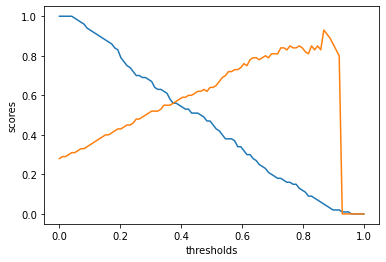

In [138]:
thresholds = np.linspace(0,1,100)
p_list = [] 
r_list = []
for t in thresholds:
    y_val_pred1 = lr.predict_proba(X_val_s)[:,1]
    predict_positive = y_val_pred1 >= t
    predict_negative = y_val_pred1 < t
    
    actual_positive = y_val == 1
    actual_negative = y_val == 0
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
  
    r = round(tp/(tp + fn),2)
    p = round(tp/(tp + fp),2) if  tp != 0 and fp != 0 else 0
   
    if r==p:
        print(t)
    
    r_list.append(r)
    p_list.append(p)
    
plt.plot(thresholds,r_list, label='r')
plt.plot(thresholds,p_list, label='p')
plt.xlabel("thresholds")
plt.ylabel("scores")
plt.legend

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [145]:
f1 = []
for i in range(len(thresholds)):
    f = 2*p_list[i] * r_list[i]/(p_list[i] + r_list[i])
    f1.append((f,thresholds[i]))
max(f1, key = lambda x: x[0])

<ipython-input-145-cbb095d29fc4>:3: RuntimeWarning: invalid value encountered in double_scalars
  f = 2*p_list[i] * r_list[i]/(p_list[i] + r_list[i])


(0.5855462184873951, 0.30303030303030304)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [173]:
def train(df, y_train, c=1.0):
    X_dict = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(X_dict)
    
    lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    lr.fit(X_train, y_train)
    
    return dv, lr

In [169]:
def predict(df_val,dv, model):
    val_dict =df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    return model.predict_proba(X_val)[:,1]

In [170]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_list = []

next(kf.split(X, y ))

for train_idx, val_idx in kf.split(df ):
    df_train = df.iloc[train_idx]
    df_val = df.iloc[val_idx]   
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    df_train = df_train.drop('default',axis=1)
    df_val = df_val.drop('default',axis=1)
    
    dv, model = train(df_train,y_train)
    y_pred = predict(df_val,dv, model)
    
    auc_list.append(roc_auc_score(y_val, y_pred))
    

In [171]:
np.std(auc_list)

0.012364891558874871

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [177]:
c =[0.01, 0.1, 1, 10]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

p_list = []
for i in c:

    auc_list = []

    for train_idx, val_idx in kf.split(df ):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]   
    
        y_train = df_train.default.values
        y_val = df_val.default.values
    
        df_train = df_train.drop('default',axis=1)
        df_val = df_val.drop('default',axis=1)
    
        dv, model = train(df_train,y_train, i)
        y_pred = predict(df_val,dv, model)
    
        auc_list.append(roc_auc_score(y_val, y_pred))
    
    p_list.append((i,round(np.mean(auc_list),3), round(np.std(auc_list),3)))
p_list

[(0.01, 0.828, 0.015),
 (0.1, 0.836, 0.014),
 (1, 0.836, 0.012),
 (10, 0.838, 0.012)]

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.